In [3]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from googletrans import Translator
import pycountry

In [55]:
base_path = "/Users/therealu/Desktop/Spring 2024/POLI179/poli 179 data/People's daily/人民日报"
years = range(1970, 2024)

# Create the list of root directories dynamically
root_dirs = [os.path.join(base_path, f"{year}") for year in years]
data = []

In [56]:
# Function to process each file
def process_file(file_path):
    file_name = os.path.basename(file_path)
    date_part = os.path.splitext(file_name.split('-')[0])[0] 
    date = pd.to_datetime(date_part, format='%Y年%m月').date()
    
    encodings = ['utf-8', 'gb18030', 'big5']
    
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                text_body = file.read()
            break
        except UnicodeDecodeError:
            continue
    else:
        raise ValueError(f"Could not decode file {file_path} with the provided encodings")
    
    return date, file_name, text_body

In [57]:
# Loop through each root directory for the years 
for root_dir in root_dirs:
    # Walk through the directory and process each text file
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(subdir, file)
                date, file_name, text_body = process_file(file_path)
                data.append([date, file_name, text_body])

In [58]:
# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Date', 'FileName', 'TextBody'])

# Print the first few rows of the DataFrame
print(df.head())

         Date      FileName                                           TextBody
0  1970-07-01  1970年07月.txt  ### 中苏国境河流航行联合委员会第十六次航行例会  定于七月十日在我黑龙江省黑河镇举行\n...
1  1970-11-01  1970年11月.txt  ### 一颗红心育新人——记装甲兵部队活学活用毛泽东思想积极分子、某部教练连指导员石福田\n...
2  1970-10-01  1970年10月.txt  ### 周恩来总理会见朝鲜政府经济代表团和贸易代表团  同朝鲜战友进行了十分亲切友好谈话\n...
3  1970-06-01  1970年06月.txt  ### 《五·七指示》放光彩  自力更生种海带\n\n\n\n1970-06-01\n\n第...
4  1970-01-01  1970年01月.txt  ### 发挥人的积极因素  克服种种困难  阿开展群众性植树造林运动  在不到一个月内各地栽...


Seperate TextBody

In [59]:
# Function to parse the text
def parse_text(text, date):
    # Split text based on ### delimiter
    sections = re.split(r'###', text)
    
    # Filter out any empty sections and strip whitespace
    sections = [section.strip() for section in sections if section.strip()]
    
    # Create a DataFrame with TextBody and Date columns
    df_parsed = pd.DataFrame(sections, columns=['TextBody'])
    df_parsed['Date'] = date  # Ensure 'Date' column is correctly recorded
    return df_parsed

In [60]:
# Apply the function to each row and concatenate the results
parsed_data = pd.concat(df.apply(lambda row: parse_text(row['TextBody'], row['Date']), axis=1).to_list(), ignore_index=True)

In [61]:
parsed_data.to_csv("~/Desktop/Spring 2024/POLI179/poli 179 data/People's daily/parsed_data_1970_2023.csv", index=False)

In [2]:
parsed_data = pd.read_csv("~/Desktop/Spring 2024/POLI179/poli 179 data/People's daily/parsed_data_1970_2023.csv")

NameError: name 'pd' is not defined

In [63]:
parsed_data['Year'] = pd.to_datetime(parsed_data['Date']).dt.year.astype(int)

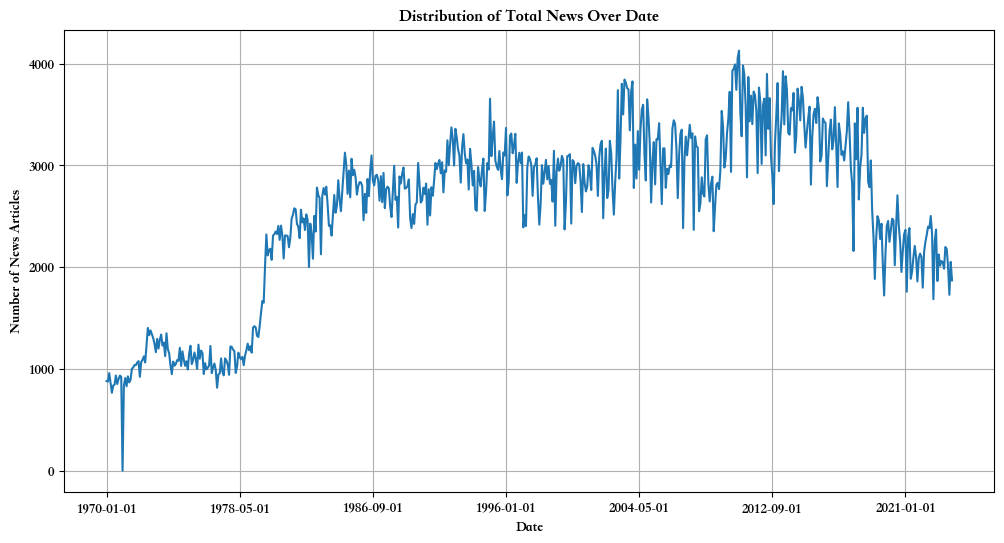

In [64]:
# Plot the distribution of total news over dates
plt.figure(figsize=(12, 6))
parsed_data['Date'].value_counts().sort_index().plot()
plt.title('Distribution of Total News Over Date')
plt.xlabel('Date')
plt.ylabel('Number of News Articles')
plt.grid(True)
plt.savefig('distribution_of_total_news_over_date.png')
plt.show()

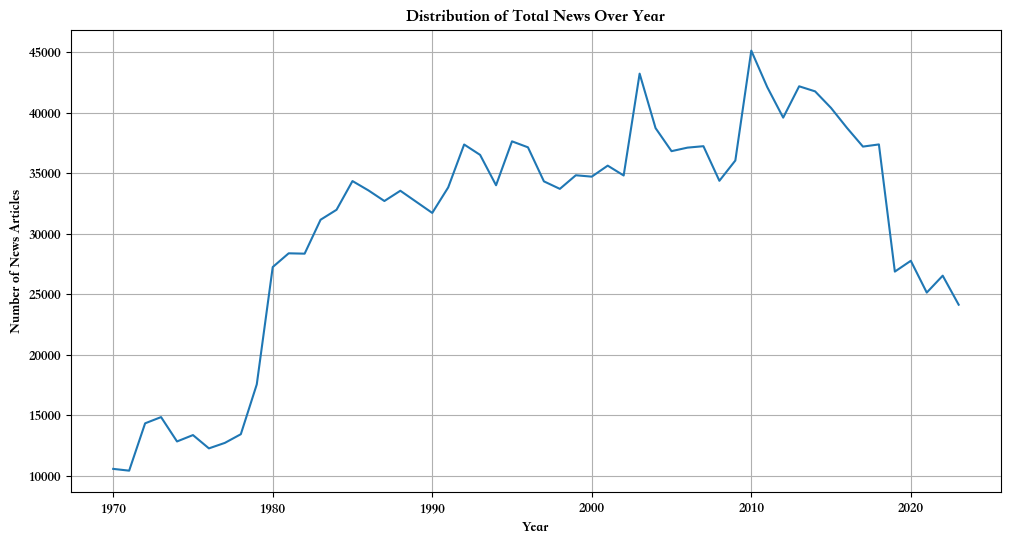

In [65]:
# Plot the distribution of total news over dates
plt.figure(figsize=(12, 6))
parsed_data['Year'].value_counts().sort_index().plot()
plt.title('Distribution of Total News Over Year')
plt.xlabel('Year')
plt.ylabel('Number of News Articles')
plt.grid(True)
plt.savefig('distribution_of_total_news_over_year.png')
plt.show()

In [66]:
# Define the keywords to filter the body text
keywords = ["移民", "流动人口", "外地人", "民工", "进城务工人员", "新市民", "盲流", "随迁子女", "落户", "户口迁移", "人口迁移","流浪乞讨人员","城乡移民"]

In [67]:
def keyword_count(row, keywords):
    text = row['TextBody']
    counts = [text.count(keyword) for keyword in keywords if keyword in text]
    total_occurrences = sum(counts)
    return total_occurrences > 2

In [68]:
# Filter the parsed data to keep only the rows where "Body Text" contains any of the keywords
pattern = '|'.join(keywords)
filtered_data = parsed_data[parsed_data.apply(lambda row: keyword_count(row, keywords), axis=1)]
print(filtered_data.head())

                                               TextBody        Date  Year
189   抓好下乡知识青年的工作\n\n\n\n1970-07-09\n\n第1版()\n\n专栏：社...  1970-07-01  1970
472   庄稼院里的好医生——记在贺兰山下插队落户的医务人员王幼文的事迹\n\n\n\n1970-07...  1970-07-01  1970
533   巴勒斯坦游击队猛攻以色列侵略军　《法塔赫报》谴责种种取消巴勒斯坦革命的“和平解决”阴谋，强调...  1970-07-01  1970
816   发扬我军军政一致、军民一致的光荣革命传统  解放军广泛开展拥政爱民活动\n\n\n\n197...  1970-07-01  1970
1399  治水史上谱新篇——记河北省人民治理海河的伟大斗争\n\n\n\n1970-11-18\n\n...  1970-11-01  1970


In [69]:
#for 移民，ensure it about internal migration
countries_english = [country.name for country in pycountry.countries if country.name != "China"]

translator = Translator()
countries_chinese = [translator.translate(name, src='en', dest='zh-CN').text for name in countries_english]

In [70]:
pattern_exclusions = '|'.join(countries_chinese)
filtered_data = filtered_data[(~filtered_data['TextBody'].str.contains(pattern_exclusions, regex=True, na=False))]

In [71]:
other_pattern = '外国人|华侨|巴基斯坦|朝鲜'
filtered_data =filtered_data[~filtered_data['TextBody'].str.contains(other_pattern)]

In [72]:
filtered_data.drop_duplicates()

,TextBody,Date,Year
189,抓好下乡知识青年的工作\n\n\n\n1970-07-09\n\n第1版()\n\n专栏：社...,1970-07-01,1970
472,庄稼院里的好医生——记在贺兰山下插队落户的医务人员王幼文的事迹\n\n\n\n1970-07...,1970-07-01,1970
1399,治水史上谱新篇——记河北省人民治理海河的伟大斗争\n\n\n\n1970-11-18\n\n...,1970-11-01,1970
1400,治理海河水系“北四河”工程开工\n\n\n\n1970-11-18\n\n第1版()\n\n...,1970-11-01,1970
3111,在毛主席的“一定要根治海河”伟大号召鼓舞下 河北治理大清河工程提前完工\n\n\n\n19...,1970-06-01,1970
...,...,...,...
1627294,开发岗位、优化服务、培训技能……湖南多举措促进农民工省内就业\n就近能务工挣钱又顾家\n人民...,2023-06-01,2023
1627389,贝壳找房平台上线五周年“一体两翼”布局护航美好居住\n\n2023年06月15日\n \n第...,2023-06-01,2023
1627514,我国已建成村级公共法律服务实体平台54.9万个\n\n2023年06月17日\n \n第 0...,2023-06-01,2023
1627517,落实落细就业优先政策（新时代新征程新伟业·坚定不移推动高质量发展）\n\n》（\n2023年...,2023-06-01,2023


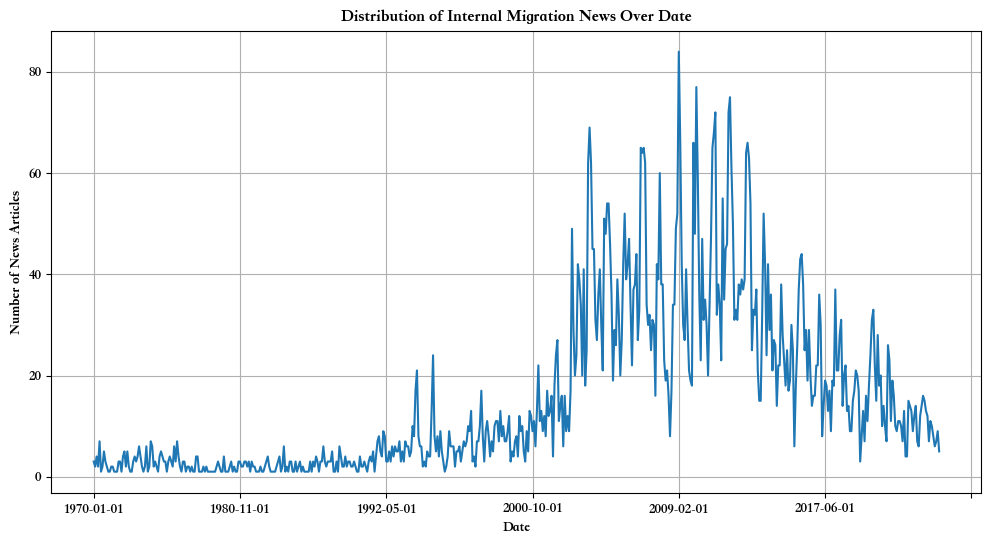

In [73]:
plt.figure(figsize=(12, 6))
filtered_data['Date'].value_counts().sort_index().plot()
plt.title('Distribution of Internal Migration News Over Date')
plt.xlabel('Date')
plt.ylabel('Number of News Articles')
plt.grid(True)
plt.savefig('distribution_of_filtered_total_news_over_date.png')
plt.show()

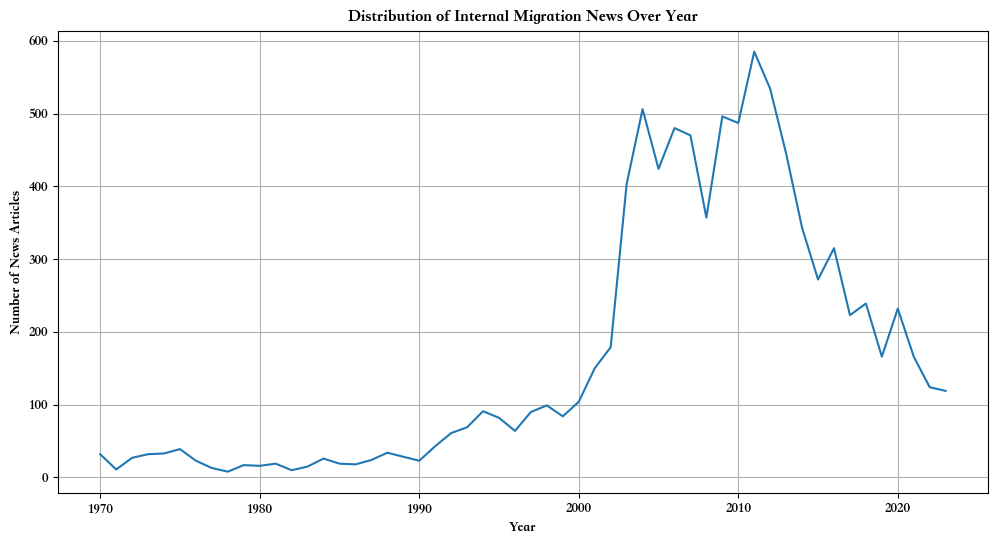

In [74]:
plt.figure(figsize=(12, 6))
filtered_data['Year'].value_counts().sort_index().plot()
plt.title('Distribution of Internal Migration News Over Year')
plt.xlabel('Year')
plt.ylabel('Number of News Articles')
plt.grid(True)
plt.savefig('distribution_of_filtered_total_news_over_date.png')
plt.show()

In [5]:
#add id
def number_to_letters(num):
    letters = ''
    while num > 0:
        num -= 1  # Adjust for 0-indexing in Python
        letters = chr(65 + (num % 26)) + letters
        num = num // 26
    return letters

filtered_data['id'] = [number_to_letters(i + 1) for i in filtered_data.index]


In [6]:
#Save the filtered data to a CSV file
filtered_data.to_csv("~/Desktop/Spring 2024/POLI179/poli 179 data/People's daily/filtered_data_2004_2017.csv", index=False)

In [4]:
filtered_data = pd.read_csv("~/Desktop/Spring 2024/POLI179/poli 179 data/People's daily/filtered_data_2004_2017.csv")

In [77]:
# 查询当前系统所有字体
from matplotlib.font_manager import FontManager
import subprocess

mpl_fonts = set(f.name for f in FontManager().ttflist)

print('all font list get from matplotlib.font_manager:')
for f in sorted(mpl_fonts):
    print('\t' + f)

all font list get from matplotlib.font_manager:
	.Aqua Kana
	.Keyboard
	.New York
	.SF Arabic
	.SF Arabic Rounded
	.SF Compact
	.SF Compact Rounded
	.SF NS Mono
	.SF NS Rounded
	.ThonburiUI
	Academy Engraved LET
	Al Bayan
	Al Nile
	Al Tarikh
	American Typewriter
	Andale Mono
	Apple Braille
	Apple Chancery
	Apple SD Gothic Neo
	Apple Symbols
	AppleGothic
	AppleMyungjo
	Arial
	Arial Black
	Arial Hebrew
	Arial Narrow
	Arial Rounded MT Bold
	Arial Unicode MS
	Athelas
	Avenir
	Avenir Next
	Avenir Next Condensed
	Ayuthaya
	Baghdad
	Bangla MN
	Bangla Sangam MN
	Baskerville
	Beirut
	Big Caslon
	Bodoni 72
	Bodoni 72 Oldstyle
	Bodoni 72 Smallcaps
	Bodoni Ornaments
	Bradley Hand
	Brush Script MT
	Chalkboard
	Chalkboard SE
	Chalkduster
	Charter
	Cochin
	Comic Sans MS
	Copperplate
	Corsiva Hebrew
	Courier
	Courier New
	DIN Alternate
	DIN Condensed
	Damascus
	DecoType Naskh
	DejaVu Sans
	DejaVu Sans Display
	DejaVu Sans Mono
	DejaVu Serif
	DejaVu Serif Display
	Devanagari MT
	Devanagari Sangam MN
	D

In [78]:
matplotlib.rc('font', family='Songti SC', weight='bold')

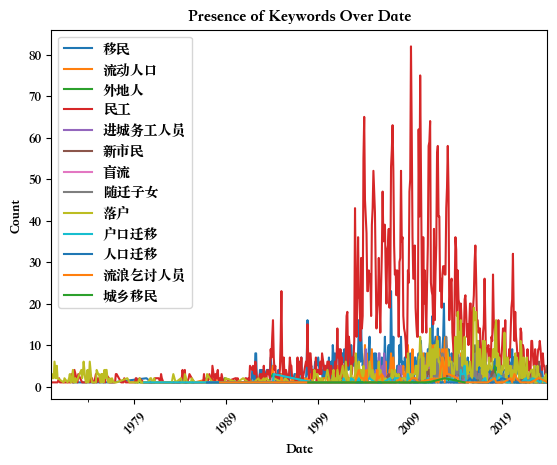

In [79]:
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])
for keyword in keywords:
    # Filter rows containing the keyword
    df_filtered = filtered_data[filtered_data['TextBody'].str.contains(keyword)]
    
    # Group by date and count occurrences
    df_grouped = df_filtered.groupby(df_filtered['Date'].dt.to_period('M')).size()
    
    # Plot each keyword's presence over date
    df_grouped.plot(label=keyword)

# Add plot details
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Presence of Keywords Over Date')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('Presence of Keywords Over Date.png')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Plot/Presence of Keywords Over Year.png'

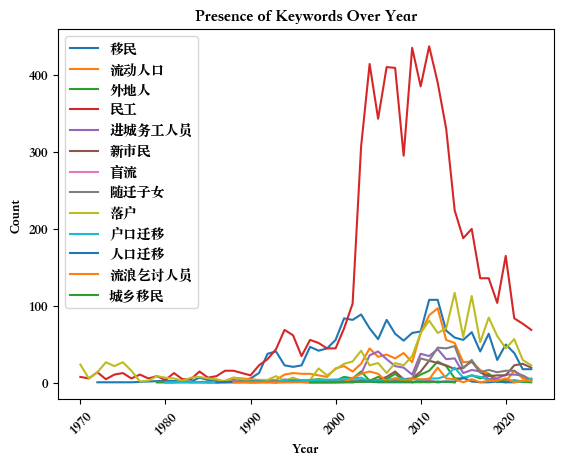

In [81]:
for keyword in keywords:
    # Filter rows containing the keyword
    df_filtered = filtered_data[filtered_data['TextBody'].str.contains(keyword)]
    
    # Group by date and count occurrences
    df_grouped = df_filtered.groupby(df_filtered['Year']).size()
    
    # Plot each keyword's presence over date
    df_grouped.plot(label=keyword)

# Add plot details
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Presence of Keywords Over Year')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('Plot/Presence of Keywords Over Year.png')
plt.show()

Inspect TextBody Length

In [ ]:
# Calculate the length of each TextBody in terms of Chinese characters
filtered_data['TextBodyLength'] = filtered_data['TextBody'].apply(len)
# Calculate minimum, maximum, median, and mean of TextBody lengths
min_length = filtered_data['TextBodyLength'].min()
max_length = filtered_data['TextBodyLength'].max()
median_length = filtered_data['TextBodyLength'].median()
mean_length = filtered_data['TextBodyLength'].mean()

# Print the results
print(f"Minimum TextBody Length: {min_length} characters")
print(f"Maximum TextBody Length: {max_length} characters")
print(f"Median TextBody Length: {median_length} characters")
print(f"Mean TextBody Length: {mean_length} characters")

In [ ]:
# Find the row with the maximum TextBody length
max_length_row = filtered_data[filtered_data['TextBodyLength'] == filtered_data['TextBodyLength'].max()]

# Print the TextBody of the row with the maximum length
print("TextBody with the Maximum Length:")
print(max_length_row['TextBody'].iloc[0])

In [ ]:
# Find the row with the maximum TextBody length
min_length_row = filtered_data[filtered_data['TextBodyLength'] == filtered_data['TextBodyLength'].min()]

# Print the TextBody of the row with the maximum length
print("TextBody with the Minimum Length:")
print(min_length_row['TextBody'].iloc[0])

In [ ]:
# Creating a histogram with these bins
plt.hist(filtered_data['TextBodyLength'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of TextBody Lengths')
plt.xlabel('Length of TextBody (Characters)')
plt.ylabel('Frequency')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()